In [2]:
import glob, re, os, time
import numpy as np
import xarray as xr
from pathlib import Path
import numpy as np, xarray as xr
from pyproj import Transformer
import matplotlib.pyplot as plt
import contextily as cx
import os, re, glob
from pprint import pprint
from lopo_point_loader import lopo_split_by_pass
from shard_builder import build_shards
import json
from sharded_dataset import load_index, split_by_cycle_pass, ShardedFlatDataset
from torch.utils.data import DataLoader
import torch
    import contextily as cx; cx.add_basemap(plt.gca(), source=cx.providers.Esri.WorldImagery, crs="EPSG:4326", attribution=False)

                                                                   
files = sorted(glob.glob("../data/*.nc")) or sorted(glob.glob("..data/*.nc"))
if not files:
    raise FileNotFoundError("No netCDF files found in ../data/ or ..data/")

len(files), files[:3]


(114,
 ['../data/SWOT_L2_LR_SSH_Expert_026_231_20250101T013336_20250101T022504_PIC2_01.nc',
  '../data/SWOT_L2_LR_SSH_Expert_026_244_20250101T124225_20250101T133353_PIC2_01.nc',
  '../data/SWOT_L2_LR_SSH_Expert_026_259_20250102T013407_20250102T022535_PIC2_02.nc'])

In [32]:
PASS_RE = re.compile(r"_(\d{3})_(\d{3})_\d{8}T\d{6}")

def parse_cycle_pass(path: str):
    m = PASS_RE.search(os.path.basename(path))
    if not m: 
        raise ValueError(f"cannot parse cycle/pass: {path}")
    return int(m.group(1)), int(m.group(2))

pairs = [parse_cycle_pass(f) for f in files]
unique_passes = sorted(set(pairs))
len(unique_passes), unique_passes[:10]

(114,
 [(26, 231),
  (26, 244),
  (26, 259),
  (26, 272),
  (26, 287),
  (26, 300),
  (26, 315),
  (26, 328),
  (26, 341),
  (26, 356)])

In [33]:
nc_path = files[0]
print("Opening:", nc_path)
ds = xr.open_dataset(nc_path)


Opening: ../data/SWOT_L2_LR_SSH_Expert_026_231_20250101T013336_20250101T022504_PIC2_01.nc


In [34]:

                
bbox = dict(min_lon=-99, min_lat=17, max_lon=-79, max_lat=31)

v_lat  = "latitude"
v_lon  = "longitude"
v_time = "time"
v_val  = "ssh_karin"                                   

ds = xr.open_dataset(nc_path)

                                           
lat = ds[v_lat]                                           
lon = ds[v_lon]                                           
val = ds[v_val]                                           
tim = ds[v_time]                               

t2d, _ = xr.broadcast(tim, val)                           
t_sec = (t2d.astype("datetime64[s]").astype("int64")).astype("float32")

lon_wrapped = ((lon + 180.0) % 360.0) - 180.0

                            
m = (
    np.isfinite(lat) & np.isfinite(lon_wrapped) & np.isfinite(val) & np.isfinite(t_sec) &
    (lon_wrapped >= bbox["min_lon"]) & (lon_wrapped <= bbox["max_lon"]) &
    (lat >= bbox["min_lat"]) & (lat <= bbox["max_lat"])
)

lat_f = lat.values[m].astype("float32")
lon_f = lon_wrapped.values[m].astype("float32")
y_f   = val.values[m].astype("float32")
t_f   = t_sec.values[m]                        

lat_f.shape, lon_f.shape, y_f.shape, t_f.shape


((39432,), (39432,), (39432,), (39432,))

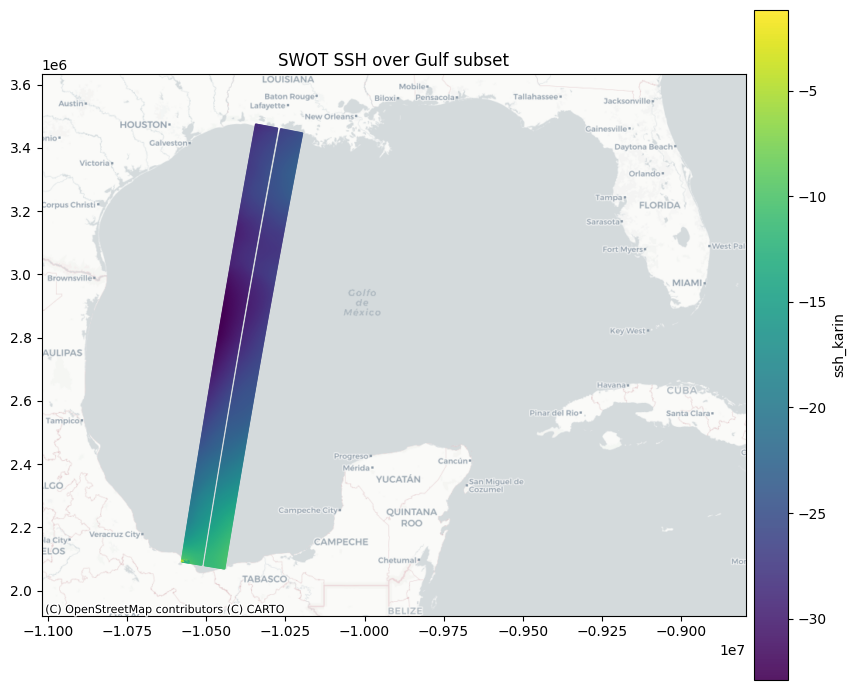

In [35]:
                      
max_pts = 400_000
if lat_f.size > max_pts:
    idx = np.random.default_rng(0).choice(lat_f.size, size=max_pts, replace=False)
    lat_p, lon_p, y_p = lat_f[idx], lon_f[idx], y_f[idx]
else:
    lat_p, lon_p, y_p = lat_f, lon_f, y_f

                      
to_3857 = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
x, y = to_3857.transform(lon_p, lat_p)

fig, ax = plt.subplots(figsize=(9, 7))
sc = ax.scatter(x, y, s=2, c=y_p, cmap="viridis", linewidths=0, alpha=0.9)
ax.set_aspect("equal")
ax.set_xlim(*to_3857.transform([bbox["min_lon"], bbox["max_lon"]], [0,0])[0])
ax.set_ylim(*to_3857.transform([0,0], [bbox["min_lat"], bbox["max_lat"]])[1])
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs="EPSG:3857")
cb = plt.colorbar(sc, ax=ax, pad=0.01)
cb.set_label(v_val)
ax.set_title("SWOT SSH over Gulf subset")
plt.tight_layout()


In [36]:
                                                                                                     


                                      
files = sorted(glob.glob("../data/*.nc")) or sorted(glob.glob("..data/*.nc"))
if not files:
    raise FileNotFoundError("No netCDF files found in ../data/ or ..data/")
print(f"Found {len(files)} files. First: {files[0]}")

                              
bbox = dict(min_lon=-99, min_lat=17, max_lon=-79, max_lat=31)
v_lat  = "latitude"                        
v_lon  = "longitude"                                         
v_time = "time"
v_val  = "ssh_karin"                    

                                                                
PASS_RE = re.compile(r"_(\d{3})_(\d{3})_\d{8}T\d{6}")

def parse_cycle_pass(path: str):
    m = PASS_RE.search(os.path.basename(path))
    if not m:
        raise ValueError(f"cannot parse cycle/pass from: {path}")
    return int(m.group(1)), int(m.group(2))

def to_seconds(tarr: np.ndarray) -> np.ndarray:
    t = np.asarray(tarr)
    if np.issubdtype(t.dtype, np.datetime64):
        return t.astype("datetime64[s]").astype("int64").astype(np.float32)
    return t.astype(np.float32)

def process_file(nc_path: str):
    cyc, pas = parse_cycle_pass(nc_path)
    ds = xr.open_dataset(nc_path)

                
    lat = ds[v_lat]                                           
    lon = ds[v_lon]                                           
    val = ds[v_val]                                           
    tim = ds[v_time]                               

                                       
    t2d, _ = xr.broadcast(tim, val)                           
    t_sec = to_seconds(t2d.values)

                                   
    lon_wrapped = ((lon + 180.0) % 360.0) - 180.0

                        
    m = (
        np.isfinite(lat) & np.isfinite(lon_wrapped) & np.isfinite(val) & np.isfinite(t2d) &
        (lon_wrapped >= bbox["min_lon"]) & (lon_wrapped <= bbox["max_lon"]) &
        (lat >= bbox["min_lat"]) & (lat <= bbox["max_lat"])
    ).values

             
    lat_f = lat.values[m].astype(np.float32)
    lon_f = lon_wrapped.values[m].astype(np.float32)
    y_f   = val.values[m].astype(np.float32)
    t_f   = t_sec[m].astype(np.float32)

                          
    cycle_f = np.full(lat_f.shape[0], cyc, dtype=np.int16)
    pass_f  = np.full(lat_f.shape[0], pas, dtype=np.int16)

    ds.close()
    return lat_f, lon_f, t_f, y_f, cycle_f, pass_f

                                                              
acc_lat, acc_lon, acc_t, acc_y, acc_cyc, acc_pas = [], [], [], [], [], []
for f in files:
    lat_f, lon_f, t_f, y_f, cycle_f, pass_f = process_file(f)
    if lat_f.size == 0:
        continue
    acc_lat.append(lat_f); acc_lon.append(lon_f); acc_t.append(t_f); acc_y.append(y_f)
    acc_cyc.append(cycle_f); acc_pas.append(pass_f)

if not acc_lat:
    raise RuntimeError("No points after bbox/finite filtering")

lat_all  = np.concatenate(acc_lat)
lon_all  = np.concatenate(acc_lon)
t_all    = np.concatenate(acc_t)
y_all    = np.concatenate(acc_y)
cycle_all= np.concatenate(acc_cyc)
pass_all = np.concatenate(acc_pas)

print("Final shapes:")
print(" lat:",   lat_all.shape)
print(" lon:",   lon_all.shape)
print(" time:",  t_all.shape)
print(" ssh:",   y_all.shape)
print(" cycle:", cycle_all.shape)
print(" pass:",  pass_all.shape)

                                        
keys, counts = np.unique(np.stack([cycle_all, pass_all], axis=1), axis=0, return_counts=True)
print("Unique (cycle,pass) in subset and counts (first 10):")
for (c,p), n in list(zip(keys, counts))[:10]:
    print(f"  ({int(c):03d},{int(p):03d}) -> {int(n)} points")


Found 114 files. First: ../data/SWOT_L2_LR_SSH_Expert_026_231_20250101T013336_20250101T022504_PIC2_01.nc
Final shapes:
 lat: (2777273,)
 lon: (2777273,)
 time: (2777273,)
 ssh: (2777273,)
 cycle: (2777273,)
 pass: (2777273,)
Unique (cycle,pass) in subset and counts (first 10):
  (026,231) -> 39432 points
  (026,244) -> 28039 points
  (026,259) -> 30256 points
  (026,272) -> 34787 points
  (026,300) -> 35280 points
  (026,328) -> 21948 points
  (026,341) -> 524 points
  (026,369) -> 35189 points
  (026,397) -> 31304 points
  (026,410) -> 10778 points


In [30]:
split = lopo_split_by_pass(
    cycle_all, pass_all,
    val_ratio=0.10, test_ratio=0.10,
    seed=1337,                                  
    explicit_val=None,
    explicit_test=None
)

print("train passes:", len(split["train"]))
print("val passes:  ", len(split["val"]))
print("test passes: ", len(split["test"]))
pprint({"val": split["val"], "test": split["test"]})

train passes: 74
val passes:   9
test passes:  9
{'test': [(27, 259),
          (27, 425),
          (27, 438),
          (26, 328),
          (28, 22),
          (26, 466),
          (26, 231),
          (27, 494),
          (28, 300)],
 'val': [(27, 397),
         (26, 259),
         (28, 550),
         (28, 466),
         (28, 565),
         (26, 369),
         (27, 160),
         (27, 578),
         (26, 272)]}


## Cycle and pass comparisons

## Sharding

In [2]:
files = list(Path("../../data/raw/SWOT").glob("*.nc"))
                              
bbox = {"min_lon":-99,"min_lat":17,"max_lon":-79,"max_lat":31}
written = build_shards(
    files,
    bbox=bbox,
    out_dir="../../data/shard/test_02/whole",
    watermask_dir="../../data/watermask",
    downsampling_factor=30,
)


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


File: ../../data/watermask/seasonality_90W_20Sv1_4_2021.tif, BBox: (-90, -30, -80, -20)
File: ../../data/watermask/seasonality_100W_30Nv1_4_2021.tif, BBox: (-100, 20, -90, 30)
File: ../../data/watermask/seasonality_100W_40Nv1_4_2021.tif, BBox: (-100, 30, -90, 40)
File: ../../data/watermask/seasonality_80W_20Nv1_4_2021.tif, BBox: (-80, 10, -70, 20)
File: ../../data/watermask/seasonality_80W_30Nv1_4_2021.tif, BBox: (-80, 20, -70, 30)
File: ../../data/watermask/seasonality_90W_40Sv1_4_2021.tif, BBox: (-90, -50, -80, -40)
File: ../../data/watermask/seasonality_80W_40Nv1_4_2021.tif, BBox: (-80, 30, -70, 40)
File: ../../data/watermask/seasonality_90W_30Sv1_4_2021.tif, BBox: (-90, -40, -80, -30)
File: ../../data/watermask/seasonality_100W_20Nv1_4_2021.tif, BBox: (-100, 10, -90, 20)
File: ../../data/watermask/seasonality_80W_40Sv1_4_2021.tif, BBox: (-80, -50, -70, -40)
File: ../../data/watermask/seasonality_90W_30Nv1_4_2021.tif, BBox: (-90, 20, -80, 30)
File: ../../data/watermask/seasonality_1

/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


In [20]:
files = list(Path("../data").glob("*.nc"))
                              
bbox = {"min_lon":-99,"min_lat":17,"max_lon":-79,"max_lat":31}
written = build_shards(
    files,
    bbox=bbox,
    out_dir="./shards",
    watermask_dir="../../../data/watermask/",
    downsampling_factor=30,
)


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 6 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 4 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 4 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 3 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 6 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 3 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 3 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 1 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
Found 1 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 4 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 3 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 1 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 6 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 6 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 4 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 6 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 1 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 3 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 1 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 6 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 6 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 4 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 6 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 4 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 4 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 6 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 1 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 1 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 1 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 4 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 3 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 1 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 1 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')
/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 6 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 3 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 4 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 6 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 4 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 4 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 3 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 1 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 3 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 6 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 3 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 6 filenames that fit the bounding box
../../../data/watermask/seasonality_80W_20Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_80W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_100W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_100W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_20Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


Found 2 filenames that fit the bounding box
../../../data/watermask/seasonality_90W_30Nv1_4_2021.tif
../../../data/watermask/seasonality_90W_40Nv1_4_2021.tif


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


In [ ]:
80,90,100 W, 20, 30, 40 N

In [ ]:

shard_dir = Path("./shards")
index = load_index(shard_dir)
splits = split_by_cycle_pass(index, val_ratio=0.10, test_ratio=0.10, seed=42)
(shard_dir / "splits.cyclepass.seed42.json").write_text(json.dumps(splits, indent=2))

splits = json.loads((shard_dir / "splits.cyclepass.seed42.json").read_text())
train_ds = ShardedFlatDataset(splits["train"])
val_ds   = ShardedFlatDataset(splits["val"])
test_ds  = ShardedFlatDataset(splits["test"])

train_loader = DataLoader(train_ds, batch_size=8192, shuffle=True,  num_workers=8, pin_memory=True,  persistent_workers=True)
val_loader   = DataLoader(val_ds,   batch_size=8192, shuffle=False, num_workers=8, pin_memory=True,  persistent_workers=True)
test_loader  = DataLoader(test_ds,  batch_size=8192, shuffle=False, num_workers=8, pin_memory=True,  persistent_workers=True)

In [22]:
n_train = len(train_loader.dataset); n_val = len(val_loader.dataset); n_test = len(test_loader.dataset)
print(n_train, n_val, n_test)

for name, ds in [("train", train_loader.dataset), ("val", val_loader.dataset), ("test", test_loader.dataset)]:
    cps = {(it["cycle"], it["pas"]) for it in ds.shards}
    print(name, len(cps), "unique (cycle,pass)")

batch = next(iter(val_loader))
assert {"lat","lon","t","y"} <= batch.keys()


2262241 238073 231685
train 74 unique (cycle,pass)
val 9 unique (cycle,pass)
test 9 unique (cycle,pass)


/Users/mako3626/SWOT/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:

def first_batch(loader):
    b = next(iter(loader))
    lat = b["lat"].detach().cpu().numpy().astype(float).ravel()
    lon = b["lon"].detach().cpu().numpy().astype(float).ravel()
    y   = b["y"].detach().cpu().numpy().astype(float).ravel()
    return lon, lat, y

def plot_batch_scatter(lon, lat, y, clip_sigma=3.0, title="First batch: lon–lat colored by SSH"):
    m = np.isfinite(y)
    yy = y[m]
    mu, sd = np.nanmean(yy), np.nanstd(yy)
    vmin, vmax = mu - clip_sigma*sd, mu + clip_sigma*sd

    fig, ax = plt.subplots(figsize=(9, 7))
    sc = plt.scatter(lon[m], lat[m], c=yy, s=4, alpha=0.8, vmin=vmin, vmax=vmax)
    plt.xlabel("Longitude (deg)")
    plt.ylabel("Latitude (deg)")
    plt.title(title)
    cbar = plt.colorbar(sc)
    cbar.set_label("SSH (m)")
    plt.tight_layout()
    plt.show()

def plot_ssh_hist(y, bins=80, title="SSH distribution (first batch)"):
    m = np.isfinite(y)
    plt.figure(figsize=(7,3))
    plt.hist(y[m], bins=bins)
    plt.xlabel("SSH (m)")
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()